# Imports & Load Data
作業に必要なライブラリをインポートして、 以下のデータを読み込みます。

* stock_price : 株価情報
* stock_list : 銘柄情報
* stock_fin : 財務諸表
* stock_labels : 目的変数

In [68]:
!pip install graphviz

In [94]:
import os
import pickle
import sys
import warnings
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb
from scipy.stats import spearmanr
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.auto import tqdm
from graphviz import Digraph
from scipy.stats import spearmanr

# 表示用の設定を変更します
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

In [95]:
# python 3.7.3であることを確認します
import sys
print(sys.version)

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [96]:
# データセット保存先ディレクトリ（""の中身はご自身の環境に合わせて定義してください。）
dataset_dir="/path/to"

In [97]:
# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
    "stock_fin": f"{dataset_dir}/stock_fin.csv.gz",
    # 本チュートリアルでは使用しないため、コメントアウトしています。
    # "stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv.gz",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)

stock_list
stock_price
stock_fin
stock_labels


# 欠損値処理

# Submit Model

In [98]:
def get_feature_columns(dfs, train_X, column_group="fundamental+technical"):
    # 特徴量グループを定義
    # ファンダメンタル
    fundamental_cols = dfs["stock_fin"].select_dtypes("float64").columns
    fundamental_cols = fundamental_cols[
        fundamental_cols != "Result_Dividend DividendPayableDate"
        ]
    fundamental_cols = fundamental_cols[fundamental_cols != "Local Code"]
    # 価格変化率
    returns_cols = [x for x in train_X.columns if "return" in x]
    # テクニカル
    technical_cols = [
        x for x in train_X.columns if
        (x not in fundamental_cols) and (x != "code")
    ]
    columns = {
        "fundamental_only": fundamental_cols,
        "return_only": returns_cols,
        "technical_only": technical_cols,
        "fundamental+technical": list(fundamental_cols) + list(
            technical_cols),
    }
    return columns[column_group]

In [99]:
model_path = os.path.join(os.path.dirname("__file__"), "../model")
test_X_path = os.path.join(os.path.dirname("__file__"), "../model/proceed_datas/test_X")
test_y_path = os.path.join(os.path.dirname("__file__"), "../model/proceed_datas/test_y")
val_X_path = os.path.join(os.path.dirname("__file__"), "../model/proceed_datas/val_X")
val_y_path = os.path.join(os.path.dirname("__file__"), "../model/proceed_datas/val_y")
train_X_path = os.path.join(os.path.dirname("__file__"), "../model/proceed_datas/train_X")
train_y_path = os.path.join(os.path.dirname("__file__"), "../model/proceed_datas/train_y")

In [100]:
# 対象の目的変数を定義
labels = {
#    "label_high_5",
#    "label_high_10",
    "label_high_20",
#    "label_low_5",
#    "label_low_10",
    "label_low_20",
}

In [101]:
# 特徴量追加済みデータ
proceed_datas = {
    "train_X",
    "train_y",
    "val_X",
    "val_y",
    "test_X",
    "test_y"
}

In [13]:
# ライブラリインポート
from sklearn.model_selection import GridSearchCV
reg_cv = GridSearchCV(xgb.XGBRegressor(), {
    "booster":["gbtree"],
    "eta": [0.109], 
    "gamma": [8.0],
    "n_estimators": [50], 
    "max_depth": [10],
    "subsample":[1],
    "colsample_bytree": [1],
    "random_state": [0],
}, verbose=1)


In [133]:
# ライブラリインポート
from sklearn.model_selection import GridSearchCV
reg_cv = GridSearchCV(xgb.XGBClassifier(), {
    'n_estimators': [494], 
    'max_depth': [8], 
    'min_child_weight': [6], 
    'learning_rate': [0.009624384025871735], 
    'subsample': [0.8328412036014541], 
    'gamma': [0], 
    'colsample_bytree': [0.715303237773365],
    'eval_metric': ['auc'],
    'tree_method': ['hist'], 
    'random_state': [0],
}, verbose=1)


In [ ]:
for label in tqdm(labels):
    data_X = os.path.join(train_X_path, f"train_X_{label}.pkl")
    with open(data_X , "rb") as f:
        train_X = pickle.load(f)
    data_y = os.path.join(train_y_path, f"train_y_{label}.pkl")
    with open(data_y , "rb") as f:
        train_y = pickle.load(f)
        
    feature_columns = get_feature_columns(dfs, train_X, column_group='fundamental+technical')
    # 訓練実施
    reg_cv.fit(train_X[feature_columns].values, train_y.values)

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [119]:
# 結果を表示
print(reg_cv.best_params_)
print(reg_cv.best_score_)

{'colsample_bytree': 0.715303237773365, 'eval_metric': 'auc', 'gamma': 0, 'learning_rate': 0.009624384025871735, 'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 494, 'random_state': 0, 'subsample': 0.8328412036014541, 'tree_method': 'hist'}
0.23430372978083472


In [120]:
best_model = reg_cv.best_estimator_

In [121]:
SELECT_FIN_DATA_COLUMNS = ['Result_FinancialStatement FiscalYear', 'Result_FinancialStatement NetSales',
       'Result_FinancialStatement OperatingIncome', 'Result_FinancialStatement OrdinaryIncome',
       'Result_FinancialStatement NetIncome', 'Result_FinancialStatement TotalAssets',
       'Result_FinancialStatement NetAssets', 'Result_FinancialStatement CashFlowsFromOperatingActivities',
       'Result_FinancialStatement CashFlowsFromFinancingActivities',
       'Result_FinancialStatement CashFlowsFromInvestingActivities', 'Forecast_FinancialStatement FiscalYear',
       'Forecast_FinancialStatement NetSales', 'Forecast_FinancialStatement OperatingIncome',
       'Forecast_FinancialStatement OrdinaryIncome', 'Forecast_FinancialStatement NetIncome',
       'Result_Dividend FiscalYear', 'Result_Dividend QuarterlyDividendPerShare',
       'Result_Dividend AnnualDividendPerShare', 'Forecast_Dividend FiscalYear',
       'Forecast_Dividend QuarterlyDividendPerShare', 'Forecast_Dividend AnnualDividendPerShare',
       'IssuedShareEquityQuote IssuedShare','Section/Products', '33 Sector(Code)', '17 Sector(Code)']

In [122]:
# 学習用データセット定義
# ファンダメンタル情報
#fundamental_cols = dfs["stock_fin"].select_dtypes("float64").columns
fundamental_cols = pd.Index(SELECT_FIN_DATA_COLUMNS)
fundamental_cols = fundamental_cols[fundamental_cols != "Result_Dividend DividendPayableDate"]
fundamental_cols = fundamental_cols[fundamental_cols != "Local Code"]
# 価格変化率
returns_cols = [x for x in train_X.columns if "return" in x]
# テクニカル
technical_cols = [x for x in train_X.columns if (x not in fundamental_cols) and (x != "code")]

In [123]:
columns = {
    "fundamental_only": fundamental_cols,
    "return_only": returns_cols,
    "technical_only": technical_cols,
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}

In [124]:
columns = {
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}

In [125]:
# 結果保存用
all_results = dict()
all_results['XGB'] = dict()

In [126]:
for label in labels:
    data_X = os.path.join(test_X_path, f"test_X_{label}.pkl")
    with open(data_X , "rb") as f:
        test_X = pickle.load(f)
    data_y = os.path.join(test_y_path, f"test_y_{label}.pkl")
    with open(data_y , "rb") as f:
        test_y = pickle.load(f)
    # データセット毎に処理
    for col in columns.keys():
        result = dict()
        # 目的変数毎に処理
        for label in tqdm(labels):
            if len(test_X[columns[col]]) > 0:
                # モデル取得
                pred_model = best_model
                # 学習
                pred_model.fit(train_X[columns[col]].values, train_y)
                # 結果データ作成
                result[label] = test_X[["code"]].copy()
                result[label]["datetime"] = test_X[columns[col]].index
                # 予測
                result[label]["predict"] = pred_model.predict(test_X[columns[col]].values)
                result[label]["predict_dir"] = np.sign(result[label]["predict"])
                # 実際の結果
                result[label]["actual"] = test_y.values
                result[label]["actual_dir"] = np.sign(result[label]["actual"])
                result[label].dropna(inplace=True)

        all_results['XGB'][col] = result

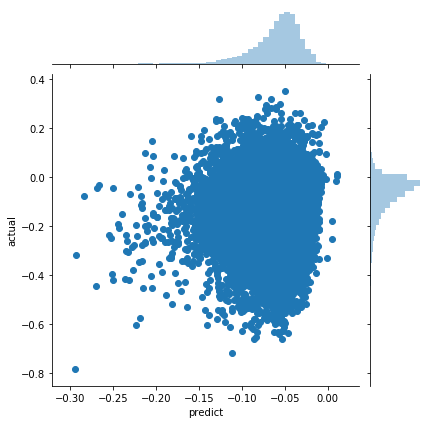

In [127]:
sns.jointplot(data=result['label_high_20'], x="predict", y="actual")

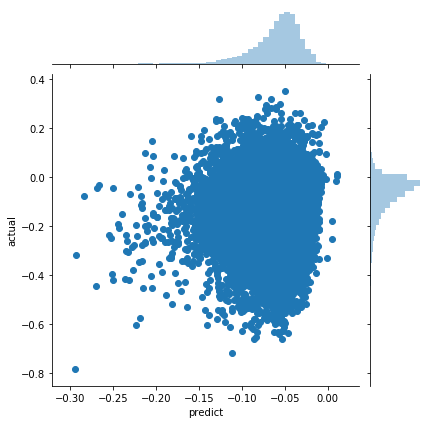

In [128]:
sns.jointplot(data=result['label_low_20'], x="predict", y="actual")

In [87]:
rf.feature_importances_.argsort()

array([ 0, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 30, 31, 28,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 62, 29, 33, 32])

In [88]:
colum_list = np.array(list(fundamental_cols) + list(technical_cols))

In [89]:
len(colum_list), len(rf.feature_importances_)

(63, 63)

Text(0.5, 0, 'Random Forest Feature Importance')

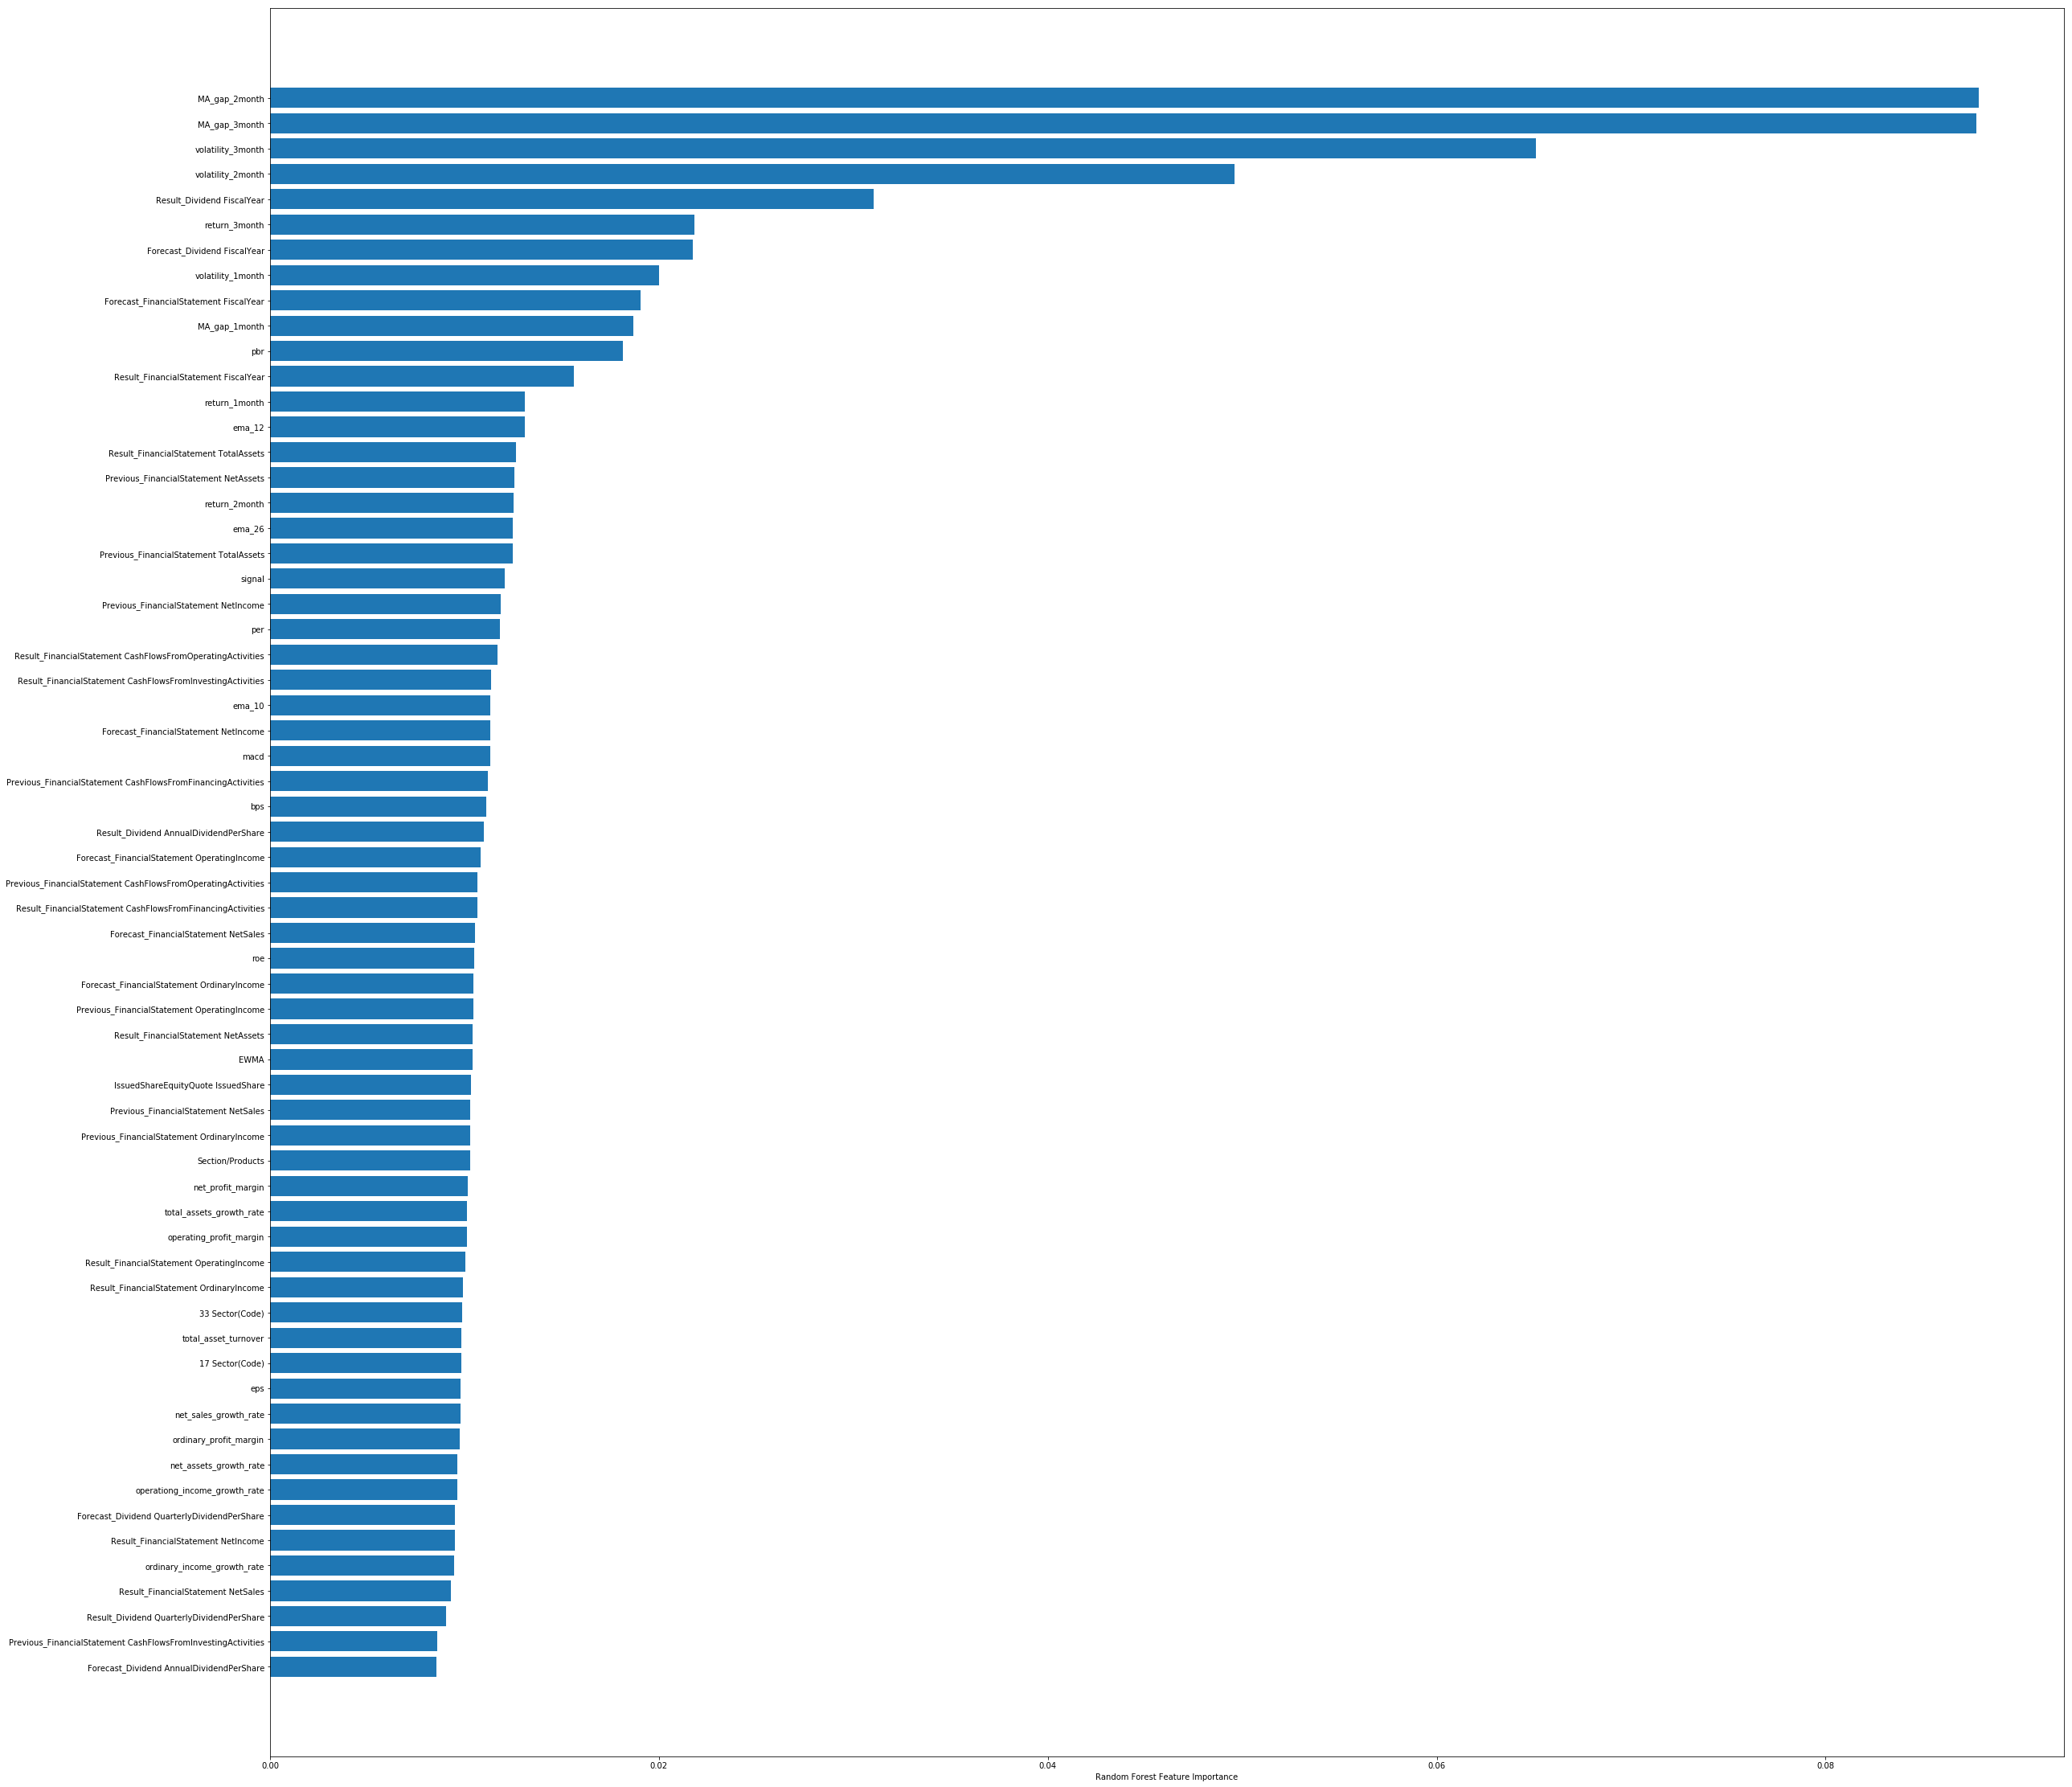

In [132]:
# 学習済みモデルを指定
rf = pred_model

# 重要度順を取得
sorted_idx = rf.feature_importances_.argsort()
# プロット
fig, ax = plt.subplots(figsize=(40, 40))
ax.barh(colum_list[sorted_idx], rf.feature_importances_[sorted_idx])
ax.set_xlabel("Random Forest Feature Importance")

In [91]:
shap.initjs()
explainer = shap.TreeExplainer(model=pred_model, feature_perturbation='tree_path_dependent', model_output='margin')
# SHAP値
shap_values = explainer.shap_values(X=train_X)
# プロット
shap.summary_plot(shap_values, train_X, plot_type="bar")

model_output = "margin" has been renamed to model_output = "raw"


ValueError: This reshape error is often caused by passing a bad data matrix to SHAP. See https://github.com/slundberg/shap/issues/580

In [63]:
shap.summary_plot(shap_values, train_X)

NameError: name 'shap_values' is not defined

In [40]:
# モデルを定義
models = {
    "rf": RandomForestRegressor,
    "extraTree": ExtraTreesRegressor,
    "gbr": GradientBoostingRegressor,
}

# 学習用データセット定義
columns = {
    "fundamental_only": fundamental_cols,
    "return_only": returns_cols,
    "technical_only": technical_cols,
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}

# 結果保存用
all_results = dict()
# モデル毎に処理
for model in tqdm(models.keys()):
    all_results[model] = dict()
    # データセット毎に処理
    for col in columns.keys():
        result = dict()
        # 目的変数毎に処理
        for label in tqdm(labels):
            if len(test_X[label][columns[col]]) > 0:
                # モデル取得
                pred_model = models[model](random_state=0)
                # 学習
                pred_model.fit(train_X[label][columns[col]].values, train_y[label])
                # 結果データ作成
                result[label] = test_X[label][["code"]].copy()
                result[label]["datetime"] = test_X[label][columns[col]].index
                # 予測
                result[label]["predict"] = pred_model.predict(test_X[label][columns[col]])
                result[label]["predict_dir"] = np.sign(result[label]["predict"])
                # 実際の結果
                result[label]["actual"] = test_y[label].values
                result[label]["actual_dir"] = np.sign(result[label]["actual"])
                result[label].dropna(inplace=True)

        all_results[model][col] = result

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


In [42]:
with open(os.path.join(model_path, f"my_model_rf_extraTree_gbr.pkl"), "wb") as f:
    # モデルをpickle形式で保存
    pickle.dump(model, f)

In [41]:
all_results.keys()

dict_keys(['rf', 'extraTree', 'gbr'])

In [43]:
results = []
for model in all_results.keys():
    for col in all_results[model]:
        tmp = pd.concat(all_results[model][col])
        tmp["model"] = model
        tmp["feature"] = col
        results.append(tmp)
results = pd.concat(results)
results["label"] = [x[0] for x in results.index]
results.head(5)

code   datetime   predict  predict_dir   actual  actual_dir model           feature  \
              datetime                                                                                          
label_high_10 2019-02-08  1301 2019-02-08  0.109417          1.0  0.07143         1.0    rf  fundamental_only   
              2019-05-13  1301 2019-05-13  0.095722          1.0  0.04379         1.0    rf  fundamental_only   
              2019-08-02  1301 2019-08-02  0.055176          1.0  0.00498         1.0    rf  fundamental_only   
              2019-11-05  1301 2019-11-05  0.172141          1.0  0.00841         1.0    rf  fundamental_only   
              2020-02-07  1301 2020-02-07  0.113166          1.0  0.01212         1.0    rf  fundamental_only   

                                  label  
              datetime                   
label_high_10 2019-02-08  label_high_10  
              2019-05-13  label_high_10  
              2019-08-02  label_high_10  
              2019-11-05  label_high_10  
              2020-02-07  label_high_10

In [9]:
# データセット保存先ディレクトリ（""の中身はご自身の環境に合わせて定義してください。）
dataset_dir="../data_dir"

In [10]:
# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
    "stock_fin": f"{dataset_dir}/stock_fin.csv.gz",
    # 本チュートリアルでは使用しないため、コメントアウトしています。
    # "stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv.gz",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)

stock_list
stock_price
stock_fin
stock_labels


In [14]:
# 学習用データセット定義
# ファンダメンタル情報
fundamental_cols = dfs["stock_fin"].select_dtypes("float64").columns
fundamental_cols = fundamental_cols[fundamental_cols != "Result_Dividend DividendPayableDate"]
fundamental_cols = fundamental_cols[fundamental_cols != "Local Code"]
# 価格変化率
returns_cols = [x for x in train_X[label].columns if "return" in x]
# テクニカル
technical_cols = [x for x in train_X[label].columns if (x not in fundamental_cols) and (x != "code")]

NameError: name 'train_X' is not defined

In [12]:
# 学習用データセット定義
columns = {
    "fundamental_only": fundamental_cols,
    "return_only": returns_cols,
    "technical_only": technical_cols,
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}

NameError: name 'returns_cols' is not defined

In [5]:
# 結果保存用変数
all_metrics = []

# データセット毎に処理
for feature in columns:
    matrix = dict()
    # モデル毎に処理
    for model in models:
        # 目的変数毎に処理
        for label in labels:
            # 処理対象データに絞り込み
            tmp_df = results[(results["model"] == model) & (results["label"] == label) & (results["feature"] == feature)]
            # RMSE
            rmse = np.sqrt(mean_squared_error(tmp_df["predict"], tmp_df["actual"]))
            # 精度
            accuracy = accuracy_score(tmp_df["predict_dir"], tmp_df["actual_dir"])
            # 相関係数
            corr = np.corrcoef(tmp_df["actual"], tmp_df["predict"])[0, 1]
            # 順位相関
            spearman_corr = spearmanr(tmp_df["actual"], tmp_df["predict"])[0]
            # 結果を保存
            matrix[label] = [rmse, accuracy, spearman_corr,corr, corr**2, feature, model, tmp_df.shape[0]]
        res = pd.DataFrame.from_dict(matrix).T
        res.columns = ["RMSE","accuracy","spearman_corr","corr","R^2 score","feature", "model", "# of samples"]
        all_metrics.append(res)
all_metrics = pd.concat(all_metrics)
all_metrics.reset_index()

NameError: name 'columns' is not defined